In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

In [2]:
data = pd.read_csv('../data/data_clean.csv', sep = "|")

In [3]:
data_clean = data

In [4]:
data_clean.drop(data_clean[data.price_aprox_usd.isna()].index, axis = 0, inplace = True)

In [5]:
#Regex

In [6]:
pat_baño = "([1-9].)(?:(?:baño|toilete))"
pat_pileta = "(?:(?:pileta|pisc|pici))"
pat_parrilla = "(?:(?:parrilla))"
pat_cochera = "(?:(?:cochera|garage))"
pat_prof = "(?:(?:profesional))"
pat_est = "(?:(?:estrenar))"
regex = re.compile(pat_pileta, flags = re.IGNORECASE)
regex2 = re.compile(pat_parrilla, flags = re.IGNORECASE)
regex3 = re.compile(pat_cochera, flags = re.IGNORECASE)
regex4 = re.compile(pat_prof, flags = re.IGNORECASE)
regex5 = re.compile(pat_est, flags = re.IGNORECASE)

In [43]:
baños = data.description.apply(lambda x: regex.findall(str(x)))
pileta = data.description.apply(lambda x: 1 if regex.search(str(x)) else 0)
parrilla = data.description.apply(lambda x: 1 if regex2.search(str(x)) else 0)
cochera = data.description.apply(lambda x: 1 if regex3.search(str(x)) else 0)
prof = data.description.apply(lambda x: 1 if regex4.search(str(x)) else 0)
estrenar = data.description.apply(lambda x: 1 if regex5.search(str(x)) else 0)

In [44]:
#Cargo las columnas de regex

In [46]:
#data_kmeans["baños"] = baños
kmeans_dummys["pileta"] = pileta
kmeans_dummys["parrilla"] = parrilla
kmeans_dummys["cochera"] = cochera
kmeans_dummys["prof"] = prof
kmeans_dummys["estrenar"] = estrenar

In [47]:
#El data_dummy2 es para probar agregando

In [48]:
#Este es para data_dummy2
features = ['price_usd_per_m2','surface_covered_in_m2']

In [49]:
#Agrego surface_covered_in_m2 y sube el R2 en el train
data_dummy2 = pd.get_dummies(data_clean, columns = ['place_name','property_type'], drop_first = True)
data_dummy2_clean = data_dummy2[data_dummy2.surface_covered_in_m2.notnull()]

In [50]:
#Separo solo las propiedades de capital federal para el model de regresion
data_clean = data_clean[data_clean.state_name == "Capital Federal"]

In [51]:
#Genero dummys para las zonas de capital y por tipo de apartamento
data_dummys = pd.get_dummies(data_clean, columns = ['place_name','property_type'], drop_first = True)

In [52]:
#Target, el mismo para cualquier caso de features
target = 'price_aprox_usd'

In [53]:
#Separo los nombres de las columnas de las dummys
lista = data_dummys.iloc[:,13:].columns.tolist()

In [54]:
#Agrego os nombres de las columnas de las dummys a features
for a in lista: 
    features.append(a)

In [55]:
features_kmeans = ['price_usd_per_m2',]

In [56]:
lista_kmeans = data_dummys.iloc[:,13:74].columns.tolist()

In [57]:
for a in lista_kmeans: 
    features_kmeans.append(a)

In [58]:
Xmean = data_dummys[features_kmeans]

In [59]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(Xmean)

In [60]:
data_kmeans = data_clean.drop(columns=["property_type","place_name"])

In [61]:
data_kmeans["group_kmeans"] = pd.Series(kmeans.labels_, index=data_kmeans.index)

In [62]:
kmeans_dummys = pd.get_dummies(data_kmeans, columns=["group_kmeans"],drop_first=True)

In [63]:
#We group the dummys into 12 clusters to improve the model

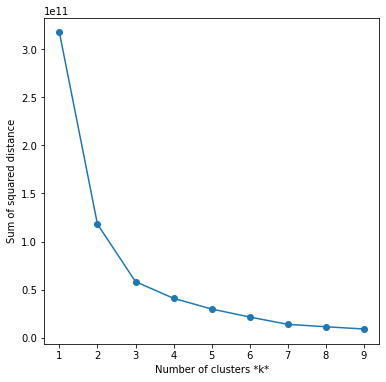

In [64]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Xmean)
    sse.append(km.inertia_)

#Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [65]:
kmeans_maks1 = kmeans_dummys[kmeans_dummys.surface_total_in_m2.isnull()]

In [66]:
kmeans_nulls_complete = kmeans_maks1.apply(lambda x: x.price_aprox_usd/x.price_usd_per_m2, axis=1)

In [67]:
kmeans_dummys.surface_total_in_m2.fillna(kmeans_nulls_complete, inplace=True)

In [68]:
features_kmeans_group = ["surface_total_in_m2","pileta","parrilla","cochera","prof","estrenar"]

In [69]:
lista_kmeans = kmeans_dummys.iloc[:,13:].columns.tolist()

In [70]:
lista_kmeans

['group_kmeans_1',
 'group_kmeans_2',
 'group_kmeans_3',
 'group_kmeans_4',
 'group_kmeans_5',
 'group_kmeans_6',
 'group_kmeans_7']

In [71]:
for a in lista_kmeans:
    features_kmeans_group.append(a)

In [72]:
kmeans_dummys_backup = kmeans_dummys

In [73]:
kmeans_dummys = kmeans_dummys[~(kmeans_dummys.price_aprox_usd <= 10000)]

In [74]:
kmeans_dummys = kmeans_dummys[~(kmeans_dummys.price_aprox_usd >= 7500000)]

In [75]:
kmeans_dummys = kmeans_dummys[kmeans_dummys.surface_total_in_m2 <=200]

In [76]:
precio = kmeans_dummys[kmeans_dummys.price_aprox_usd<=2000000].price_aprox_usd/1000
metros2 = kmeans_dummys.surface_total_in_m2

<AxesSubplot:xlabel='price_aprox_usd', ylabel='surface_total_in_m2'>

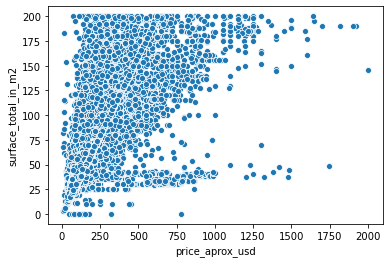

In [77]:
sns.scatterplot(precio, metros2)

In [81]:
data_clean.to_csv('kmeans_dummys.csv',index = False, sep="|")

In [ ]:
kmeans_t[featu]

In [82]:
#Genero el train_test_spit con los features y targets anteriores // Estoy probando con dummy 2
Xtrain, Xtest, ytrain, ytest = train_test_split(kmeans_dummys[features_kmeans_group], kmeans_dummys[target], random_state=1)

KeyError: "['parrilla', 'prof', 'pileta', 'cochera', 'estrenar'] not in index"

In [373]:
#Prueba con modelo de regresion normal

In [83]:
ln = LinearRegression().fit(Xtrain, ytrain)

NameError: name 'Xtrain' is not defined

In [67]:
ln.score(Xtrain, ytrain)

0.8695562255321184

In [68]:
ln.score(Xtest, ytest)

0.8465423967810862

In [377]:
#Prueba con Lasso con Cross Validation

In [84]:
lscv = LassoCV(cv=5, normalize=False, random_state=0, alphas=[1,5,10,25,100,1000,10000]).fit(Xtrain, ytrain)

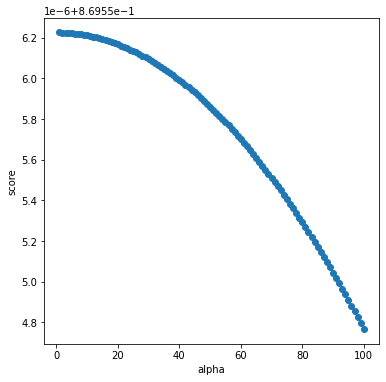

In [195]:
sse = []
lista = list(range(1,101))

for x in lista:
    ls = Lasso(x/100)
    ls.fit(Xtrain, ytrain)
    sse.append(ls.score(Xtrain, ytrain))

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(lista, sse, '-o')
plt.xlabel("alpha")
plt.ylabel('score');

In [85]:
lscv.predict(Xtest)

array([288857.45745177,  85662.08740147,  58185.9890059 , ...,
       314085.66998555, 115769.80778226,  54659.13632706])

In [88]:
lscv.coef_

array([ 2.76079085e+03,  8.70889954e+03, -8.65564540e+03,  1.26321974e+04,
        1.93781870e+03,  5.06660980e+03, -5.19010626e+05,  6.17156800e+06,
       -1.27619845e+05, -6.02491775e+05,  2.99669583e+06, -2.90867256e+05,
        2.61177309e+05])

In [99]:
#Prueba con Rigde

In [74]:
#En apha 0.01 sube el R2 al maximo
rdcv = RidgeCV(cv=5,alphas=[0.01,0.1,0.5,1,5,10]).fit(Xtrain, ytrain)

In [75]:
rdcv.score(Xtrain, ytrain)

0.8614968690330657

In [76]:
rdcv.score(Xtest, ytest)

0.8615404677501127

In [77]:
#Prueba con pipeline, no tiene sentido porque no hace falta normalizar

In [78]:
pipe = make_pipeline(StandardScaler() ,LinearRegression())

In [79]:
pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [80]:
pipe.score(Xtrain, ytrain)

0.8695562255321184

In [81]:
pipe.score(Xtest, ytest)

0.8465423967810863

In [353]:
#Statsmodels Test

In [72]:
X_constant = sm.add_constant(Xtrain)
mod = sm.OLS(ytrain, X_constant).fit()

In [73]:
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                 1.112e+04
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:50:07   Log-Likelihood:            -2.7042e+05
No. Observations:               21693   AIC:                         5.409e+05
Df Residuals:                   21679   BIC:                         5.410e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.334e+05   4

In [23]:
data.groupby(by="property_type").count()

,Unnamed: 0,operation,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,properati_url,description,title,image_thumbnail
property_type,,,,,,,,,,,,,,
PH,5751,5751,5751,5751,5562,3601,4913,5751,4552,3247,5751,5751,5751,5669
apartment,71065,71065,71064,71065,67645,51085,59735,71065,52194,31268,71065,71063,71065,68940
house,40268,40268,40246,40268,36794,24505,33510,40268,28353,12770,40268,40268,40268,39572
store,4136,4136,4136,4136,3835,2701,3155,4136,2559,105,4136,4136,4136,3927
